# SEP Spatial Distribution Analysis Tool


This tool downloads SEP intensity-time series data (and location data) from various different spacecraft and visualizes the SEP distribution using Gaussian curves in one final results plot.

It will provide a Gaussian curve fitted to the observed intensity as a function of the observers' magnetic footpoint longitude at the Sun at each time step (such as is seen in the figure below), and result in a single timeseries plot to show the temporal evolution of the calculated Gaussian center and width of the particles' distribution.
<div>
    <img src="spatial_analysis/GaussCurve_TimeSeries_29May2021_03h30.png" width="800"/>
</div>

The observers' magnetic footpoint is calculated using its location in the inner heliosphere and tracing that path back to the Sun along the Parker Magnetic Field lines. These spirals are seen when showing the fleet distribution at the beginning of this notebook.

<div class="alert alert-block alert-info">
<b>Important:</b> This tool is made for comparing observations of more than 3 spacecraft, each at unique location. For that, it currently only works with the following instruments:
<ul>
<li> Parker Solar Probe (PSP) / EpiHi-HET,</li>
<li> SOHO / ERNE-HED,</li>
<li> Solar Orbiter / EPD-HET, and</li>
<li> STEREO A / HET. </li>
</div>

## Table of Contents
1. [Load the event](#Load-the-event)
2. [Background Subtraction](#Background-Subtraction)
3. [Instrument Intercalibration](#Instrument-Intercalibration)
4. [Radial Scaling](#Radial-Scaling)
5. [Peak Fits](#Peak-Fits)
6. [Temporal Gaussian Fits](#Temporal-Gaussian-Fits)
7. [Final Results](#Final-Results)
8. [Plot a simple curve for a single timestep](#Plot-a-simple-curve-for-a-single-timestep)
- [Appendix](#Appendix)
- [Glossary](#Glossary)

In [1]:
# Import modules
import os
import datetime as dt
import numpy as np
import pandas as pd

from seppy.util import jupyterhub_data_path
from spatial_analysis import SpatialEvent as sp_event

## Load the event
[Return to top](#Table-of-Contents)

Collect the event start and end dates (specifying the start at / near the observed flare onset time), and the eruption location (in Stonyhurst coordinates).

**Inputs:**
- `startdate`: Datetime object specified at the start of the solar event, including hours and minutes.
   - e.g. `dt.datetime(2025, 12, 18, 10, 15)` for 10:15am 18-Dec-2025.
- `enddate`: Datetime object, can just use `startdate + dt.timedelta(days=2)` to indicate 2 days after the start date mentioned.
- `source_location`: The estimated location of the eruption on the Sun in Stonyhurst coordinates, in order of longitude then latitude.
   - e.g. `[63, 20]` represents N20W63.

In [2]:
# Event date and location

startdate = dt.datetime(2021, 5, 28, 22, 19)
enddate = startdate + dt.timedelta(days=1, hours=12)

# Eruption location on the Sun in Stonyhurst coords
source_location = [67, 18] # [Longitude, Latitude]

Some examples that can be tried are:

| Name | Start | Flare |
|---|---|---|
| 28 May 2021 | `(2021, 5, 28, 22, 19)` | `[ 67,  18]` |
| 28 Oct 2021 | `(2021,10, 28, 15, 17)` | `[  1, -28]` |
| 14 Mar 2022 | `(2022, 3, 14, 15,  0)` | `[110, -23]` |
| 21 Mar 2022 | `(2022, 3, 21,  2,  0)` | `[137, -35]` |
| 16 May 2023 | `(2023, 5, 16, 15,  0)` | `[np.nan, np.nan]` |
| 29 Jan 2024 | `(2024, 1, 29,  3, 54)` | `[ 86,  28]` |
| 23 Mar 2024 | `(2024, 3, 23,  0, 58)` | `[ -7,  20]` |
| 01 Sep 2024 | `(2024, 9,  1, 14, 44)` | `[np.nan, np.nan]` |

In [3]:
# Set your local path where you want to save the raw data files. 
data_path = f"{os.getcwd()}{os.sep}data"
data_path = jupyterhub_data_path(data_path)

# Set your folder where you want to save the output files and figures.
out_path = f"{os.getcwd()}{os.sep}output_spatial_analysis"

### Show the fleet distribution

A quickview of the observers locations for the event and setting up the event class.

This step uses the Solar-MACH tool (for more info, see [the Online Tool](https://solar-mach.github.io/)), which can find the solar wind speed (`obs_vsw`) for each observer or a value can be provided that will be used for all calculations.

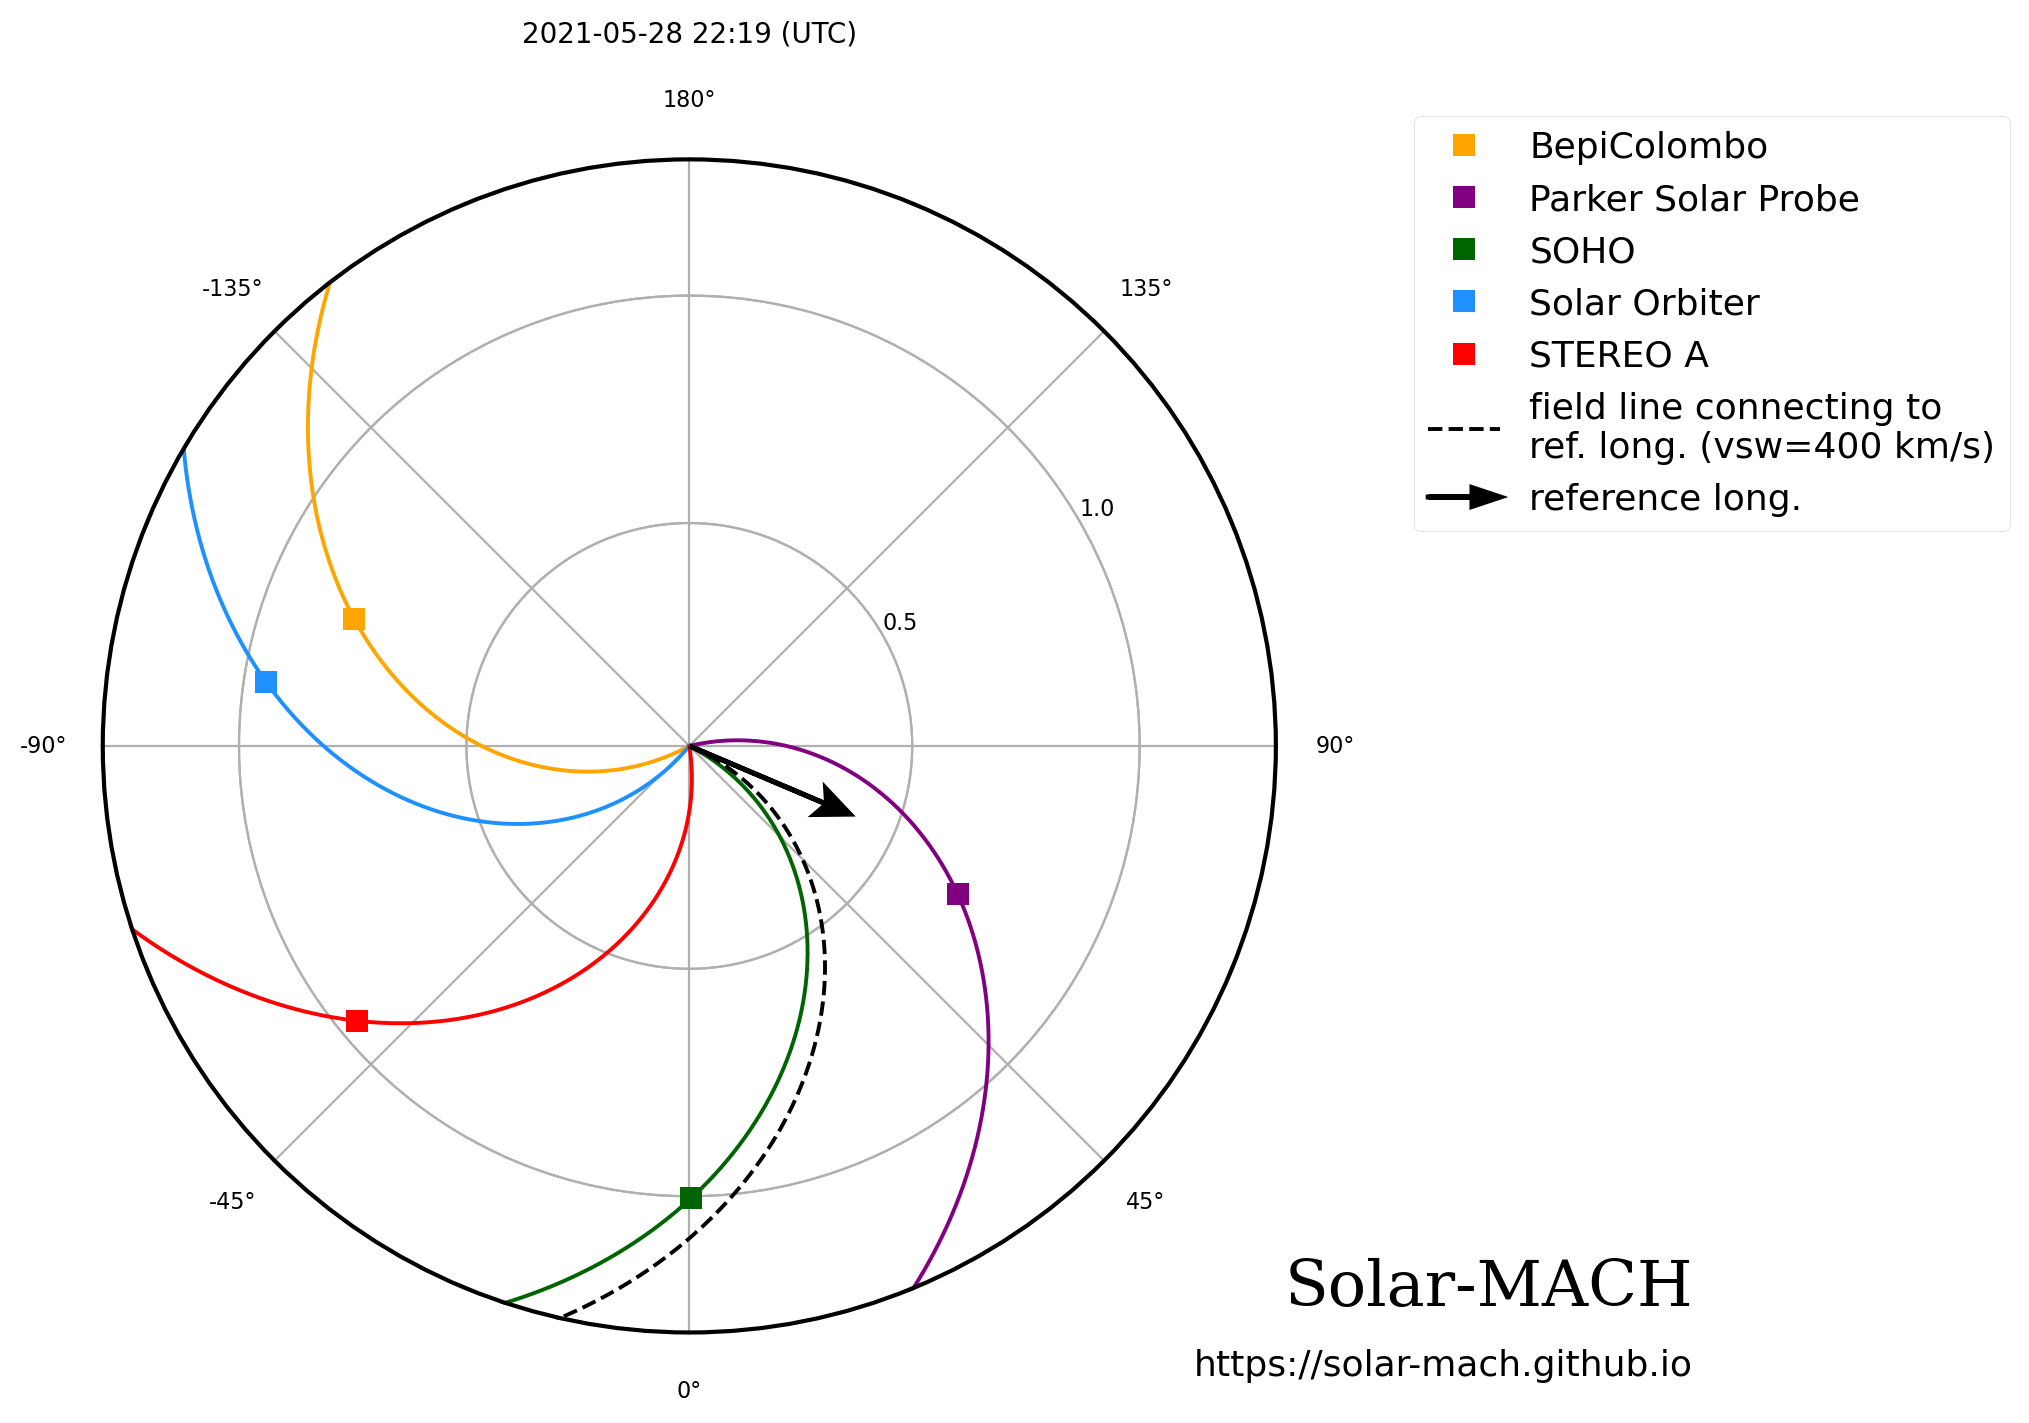

Spacecraft/Body  Stonyhurst longitude (°)  \
Spacecraft/Body                                             
BepiColombo         BepiColombo               -110.733366   
PSP                         PSP                 61.059695   
SOHO                       SOHO                  0.255711   
Solar Orbiter     Solar Orbiter                -98.578091   
STEREO A               STEREO A                -50.395401   

                 Stonyhurst latitude (°)  Heliocentric distance (AU)  \
Spacecraft/Body                                                        
BepiColombo                    -3.410311                    0.798805   
PSP                             3.108280                    0.685340   
SOHO                           -1.010817                    1.004046   
Solar Orbiter                  -0.943589                    0.950952   
STEREO A                       -6.234611                    0.963644   

                 Longitudinal separation to Earth's longitude  \
Spacecraft/Body                                                 
BepiColombo                                       -110.733364   
PSP                                                 61.059698   
SOHO                                                 0.255714   
Solar Orbiter                                      -98.578089   
STEREO A                                           -50.395399   

                 Latitudinal separation to Earth's latitude  Vsw  \
Spacecraft/Body                                                    
BepiColombo                                       -2.373459  400   
PSP                                                4.145132  400   
SOHO                                               0.026034  400   
Solar Orbiter                                      0.093263  400   
STEREO A                                          -5.197760  400   

                 Magnetic footpoint longitude (Stonyhurst)  \
Spacecraft/Body                                              
BepiColombo                                     -61.011138   
PSP                                             103.695701   
SOHO                                             62.969437   
Solar Orbiter                                   -39.194394   
STEREO A                                          9.300427   

                 Longitudinal separation between body and reference_long  \
Spacecraft/Body                                                            
BepiColombo                                            -177.733366         
PSP                                                      -5.940305         
SOHO                                                    -66.744289         
Solar Orbiter                                          -165.578091         
STEREO A                                               -117.395401         

                 Longitudinal separation between body's magnetic footpoint and reference_long  \
Spacecraft/Body                                                                                 
BepiColombo                                            -128.011138                              
PSP                                                      36.695701                              
SOHO                                                     -4.030563                              
Solar Orbiter                                          -106.194394                              
STEREO A                                                -57.699573                              

                 Latitudinal separation between body and reference_lat  
Spacecraft/Body                                                         
BepiColombo                                             -21.410311      
PSP                                                     -14.891720      
SOHO                                                    -19.010817      
Solar Orbiter                                           -18.943589      
STEREO A                                                -24.2346

In [4]:
# Set the solar wind speeds (n km/s) or use 'None' to find the speed for each observer.
obs_vsw = 400 # None

# Initialise the object 
solar_event = sp_event(dates = [startdate, enddate], 
                       filepaths = [out_path, data_path],
                       flare_loc = source_location,
                       V_sw = obs_vsw)

### Spacecraft options

Provide the spacecraft you want to use in this notebook (dictionary key), the proton energy channels for each instrument (dictionary value in list form), and the time averaging you wish to use (resampling).

More information about this step as well as other energy channel options can be found in the [Appendix](#Appendix).

<div class="alert alert-block alert-warning">
<b>Temporary notes for the user:</b> Use the SEP_Multi-Spacecraft-Plot notebook to see the full list of energy channels if you want to change this block.
</div>

In [5]:
# Define the energy channels for each observer
# Don't change the spacecraft names, just the channels
spacecraft_channels = {'PSP': [3,4], # spacecraft: [channels]
                       'SOHO': [0],
                       'STEREO A': [0],
                       'Solar Orbiter': [10,12]}

# Set the time averaging
resampling = '15min'

<div class="alert alert-block alert-info">
<b>Note for user:</b> This step can take a while. Feel free to refresh your coffee while you wait.
</div>

In [6]:
# Load the observed intensity data
solar_event.load_spacecraft_data(channels = spacecraft_channels,
                                 resampling = resampling) 

/Users/jtlang/MSc-course-2025-main/sep_tools/spatial_analysis/__init__.py:698: RuntimeWarning: Mean of empty slice
  flux_arr.append( np.nanmean([psp_df.loc[tt, f"A_F_{bin_label}"], psp_df.loc[tt, f"B_F_{bin_label}"]]) )
/Users/jtlang/MSc-course-2025-main/sep_tools/spatial_analysis/__init__.py:699: RuntimeWarning: Mean of empty slice
  unc_arr.append( np.nanmean([psp_df.loc[tt, f"A_Func_{bin_label}"], psp_df.loc[tt, f"B_Func_{bin_label}"]]) )
/Users/jtlang/MSc-course-2025-main/sep_tools/spatial_analysis/__init__.py:622: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(np.sum(x_arr**2)) / len(x_arr)
/Users/jtlang/miniforge3/envs/SEP_env/lib/python3.14/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/jtlang/miniforge3/envs/SEP_env/lib/python3.14/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious y

Data loading complete.


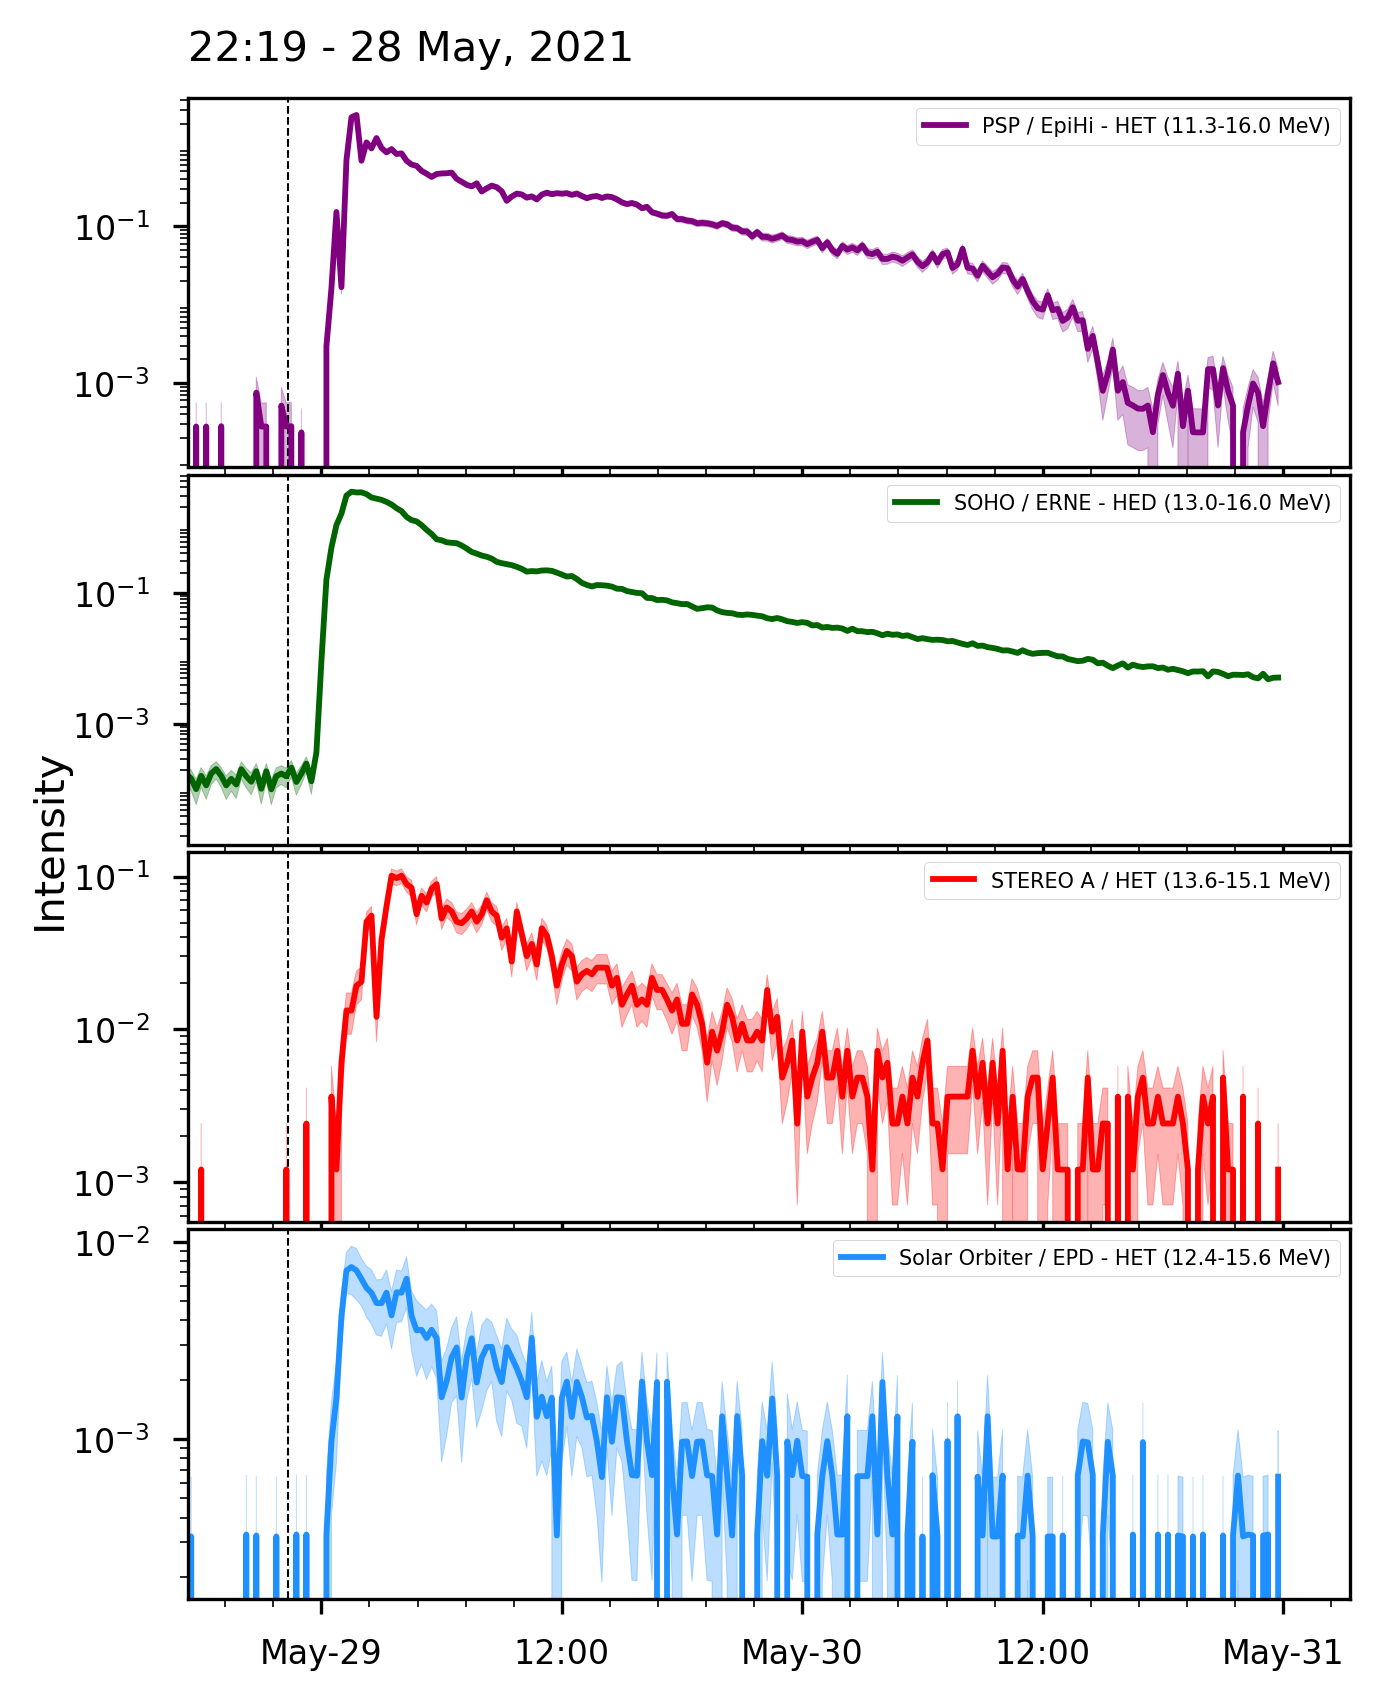

In [7]:
# Plot a quickview of the observed intensities
solar_event.plot_intensities()

## Background Subtraction
[Return to top](#Table-of-Contents)

Using a window period provided by the user, the tool calculates the average pre-event intensity and subtracts the full intensity data by this average.


This cell can be run multiple times to confirm the window period is sufficient using the figure.

More information about this step can be found in the [Appendix](#Appendix).

**Inputs:**
- `process_background_subtraction`: Set to `True` to subtract the pre-event intensity level from each data set. Set to `False` to ignore this step and move on.
- `background_window`: List of two datetime values. Time period to define the start and end of what can be considered as the time before the event is measured.
  - e.g. Can be provided in terms of the start of the solar eruption: `[startdate - dt.timedelta(hours=1), startdate + dt.timedelta(hours=1)]` will provide a time period 1 hour before the start to 1 hour after. 

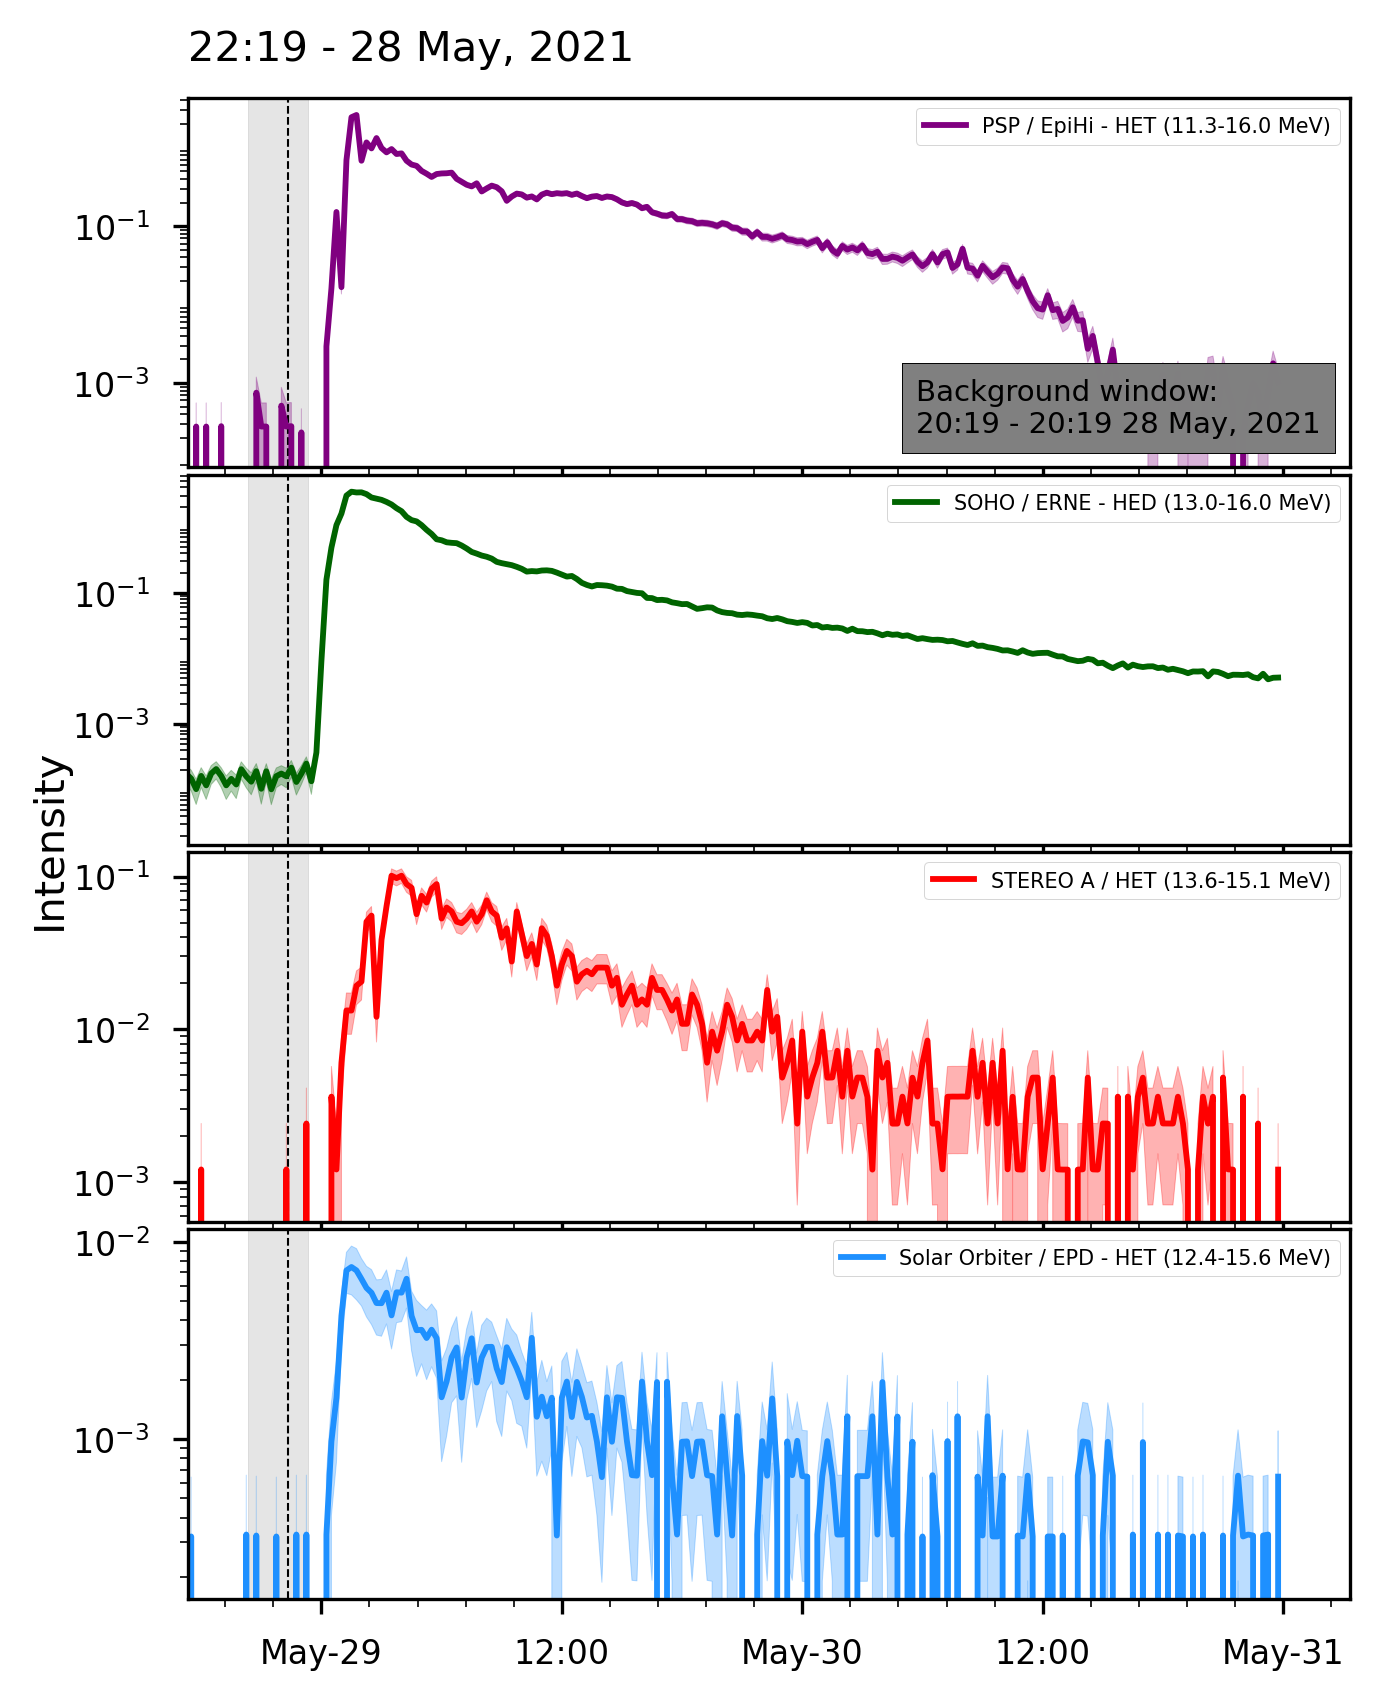

In [8]:
process_background_subtraction = True

if process_background_subtraction:
    # User input on background
    background_window = [startdate - dt.timedelta(hours=2), 
                         startdate + dt.timedelta(hours=1)]
    
    # User can check the window
    solar_event.plot_intensities(background_window = background_window)
else:
    background_window = []

In [9]:
# Perform the Background subtraction
solar_event.background_subtract(background_window = background_window, 
                                perform_process = process_background_subtraction)


Background subtraction function complete.


## Instrument Intercalibration
[Return to top](#Table-of-Contents)

This method adjusts the intensity data so as to calibrate each instrument to one common baseline. In this work, STEREO-A HET is the baseline and the only instrument that we have found (for this energy range and species) that requires an intercalibration factor is SOHO-ERNE/HED (see [Richardson et al. 2014](https://link.springer.com/article/10.1007/s11207-014-0524-8) for more information).

More information about this step and other options for different energy ranges can be found in the [Appendix](#Appendix).

**Inputs:**
- `process_intercalibration`: Set to `True` to perform this step, else use `False` to ignore this step and move on.
- `ic_values`: These are the factors that the function will use to calibrate the observations to eachother. **Only change these values if you have found intercalibration studies to support the change. These values are set for ~14 MeV protons.** 

In [10]:
process_intercalibration = True

# Intercalibration factors
ic_factors = {'PSP': 1, 
             'SOHO': 0.67, 
             'STEREO A': 1, 
             'Solar Orbiter': 1}

solar_event.intercalibrate(intercalibration_factors = ic_factors, 
                           perform_process = process_intercalibration)

Intercalibration function complete.


## Radial Scaling
[Return to top](#Table-of-Contents)

This method adjusts the intensity data to 1~au from whatever radial distance the spacecraft is measuring at according to: $$I_{1 au} = I \cdot R^{a\pm b}$$

**Inputs:**
- `process_radial_scaling`: Set to `True` to perform this step, else use `False` to ignore this step and move on.
- `radscaling_values`: A list of two floats representing the values `a` and `b` in the equation above. **Only change these values if you have found studies to support the change.** The values, $(a\pm b)=(2.14 \pm 0.26)$, are set for ~14 MeV protons and are from [Lario et al. (2006)](https://iopscience.iop.org/article/10.1086/508982).

More information about this step can be found in the [Appendix](#Appendix).

<div class="alert alert-block alert-info">
<b>Note for user:</b> This step can also take a while. Feel free to check your emails while you wait.
</div>

In [11]:
# Set to False to skip this process 
# Note that other processes also occur during this step, so even if the radial scaling is skipped, it could still take a while.
process_radial_scaling = True 

radscaling_values = [2.14, 0.26] # Values must be provided

solar_event.radial_scale(radial_scaling_factors = radscaling_values, 
                         perform_process = process_radial_scaling)

The positional data is already downloaded, would you like to use this data? 


yes or no y


SolarMACH data loaded for full time range.
Radial Scaling function complete.


## Peak Fits
[Return to top](#Table-of-Contents)

Plot the fitted Gaussian curve to the peak intensity as a function of the footprint longitude of the spacecraft at the time of the peak. 

**Inputs:**
- `window_length`: Integer value required. Provide an estimate for how many hours after the `startdate` can pass where the peak intensity might occur. 
The window to consider the peak will then be considered between the given start time and (for e.g.) 5 hours later.

If nothing is provided, the function uses a default value of 10 hours.

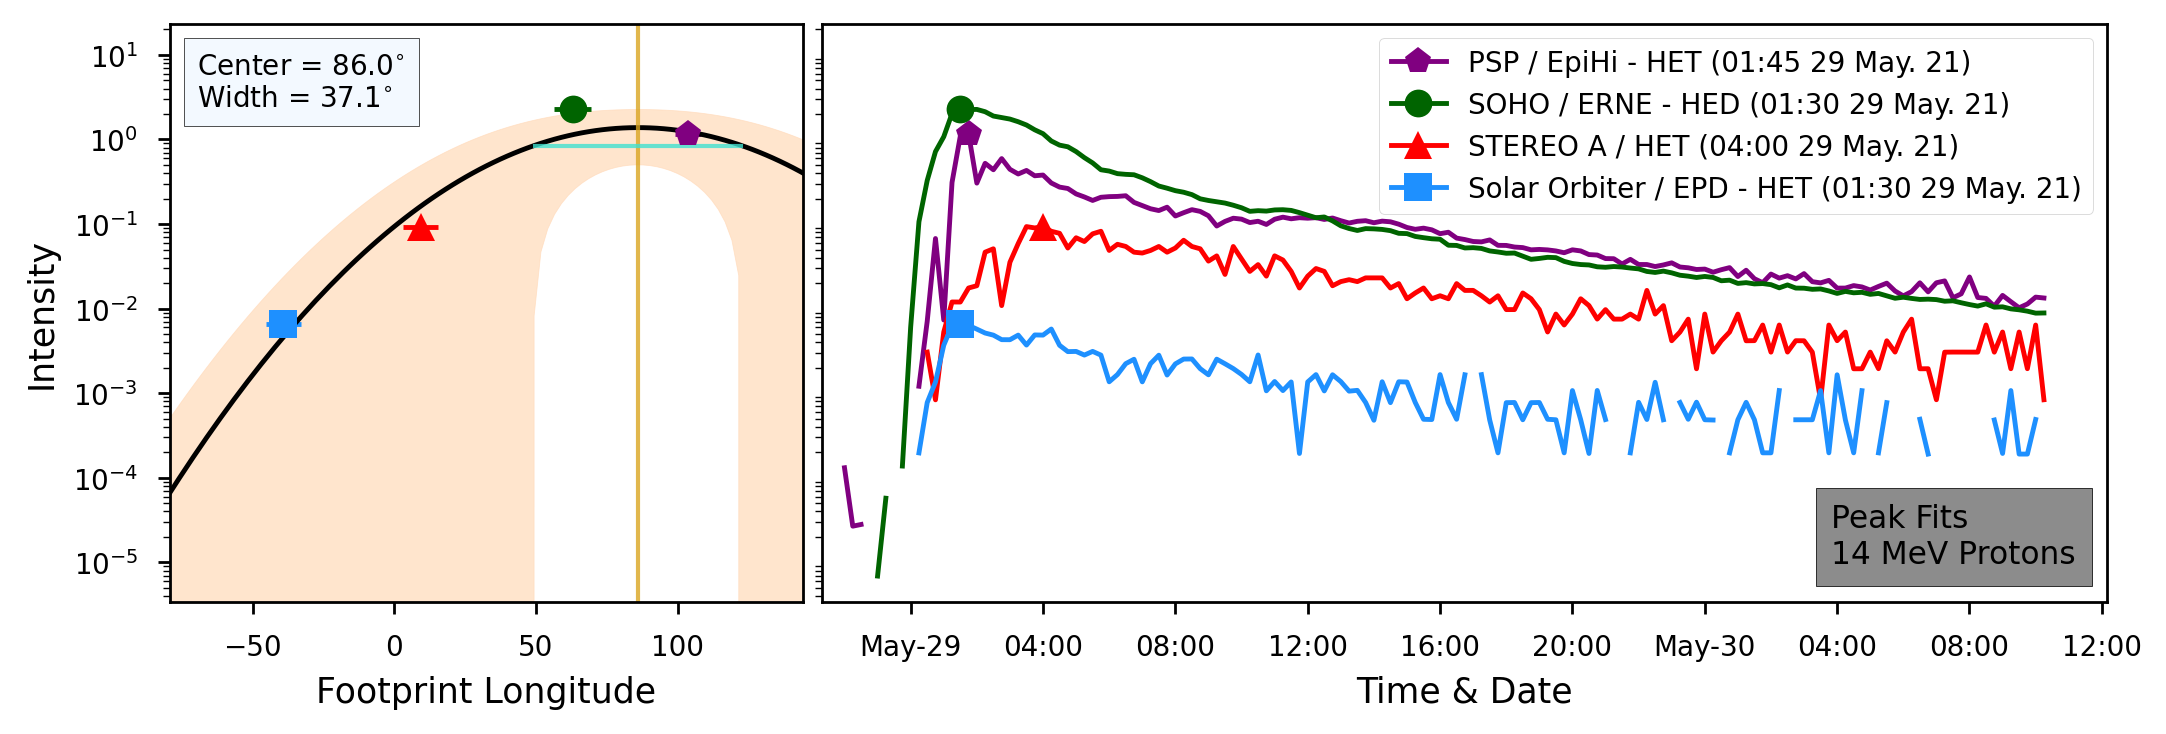

In [12]:
solar_event.plot_peak_fits(window_length = 10)

## Temporal Gaussian Fits
[Return to top](#Table-of-Contents)

A Gaussian curve is fitted to the observed intensities as a function of the observers footprint longitude at each time step.

This process uses $f=A \cdot \exp\left[\frac{-(x - X_0)^2}{2\sigma^2}\right]$ for the Gaussian curve where $A$ is the height, $X_0$ is the center, and $\sigma$ is the standard deviation which controls the width of the curve.
<div>
    <img src="spatial_analysis/GaussianCurveExamples.png" width="600"/>
</div>

The example in the figure uses $A=100$, $X_0=50$, and $\sigma=20$.

More information about this step can be found in the [Appendix](#Appendix).

  0%|          | 0/288 [00:00<?, ?it/s]

No updated Gaussian parameters were found


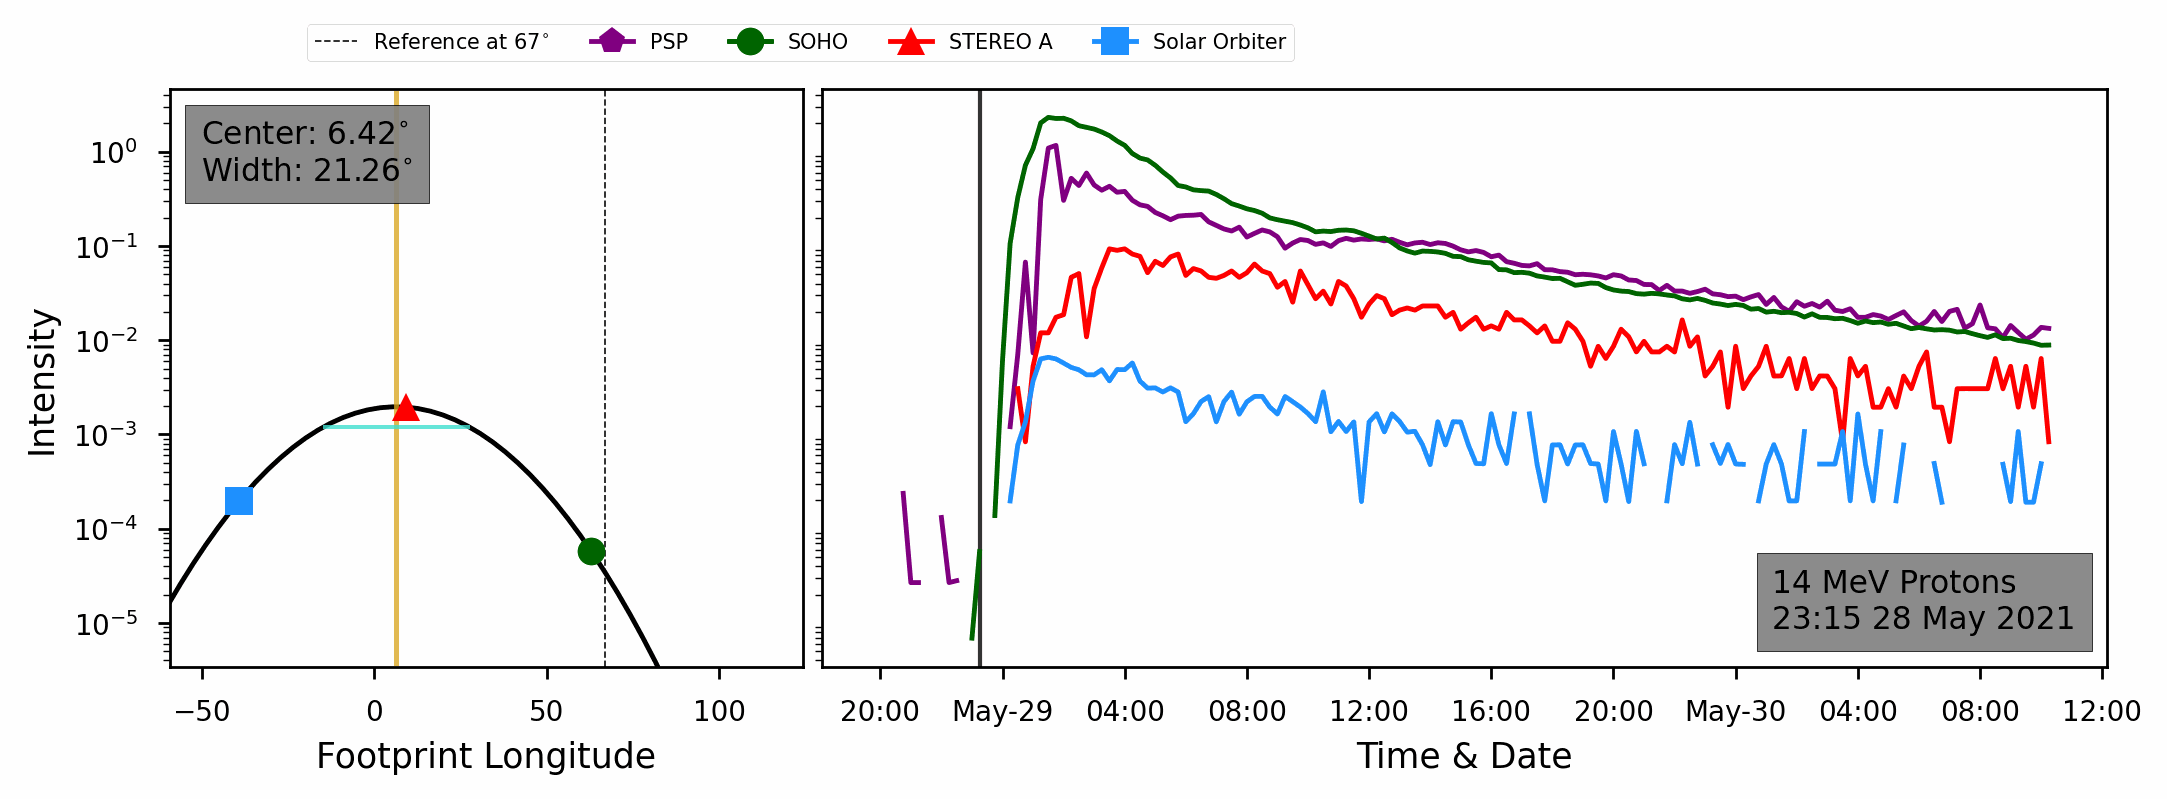

In [13]:
solar_event.calc_Gaussian_fit()

## Final Results
[Return to top](#Table-of-Contents)

This plot will show the particle intensities in units of (sr. s. cm$^2$. MeV)$^{-1}$, and the Gaussian results in degrees. The Gaussian center ($X_0$) plots the longitude of the center of the particle distribution backmapped to its footprint on the Sun.

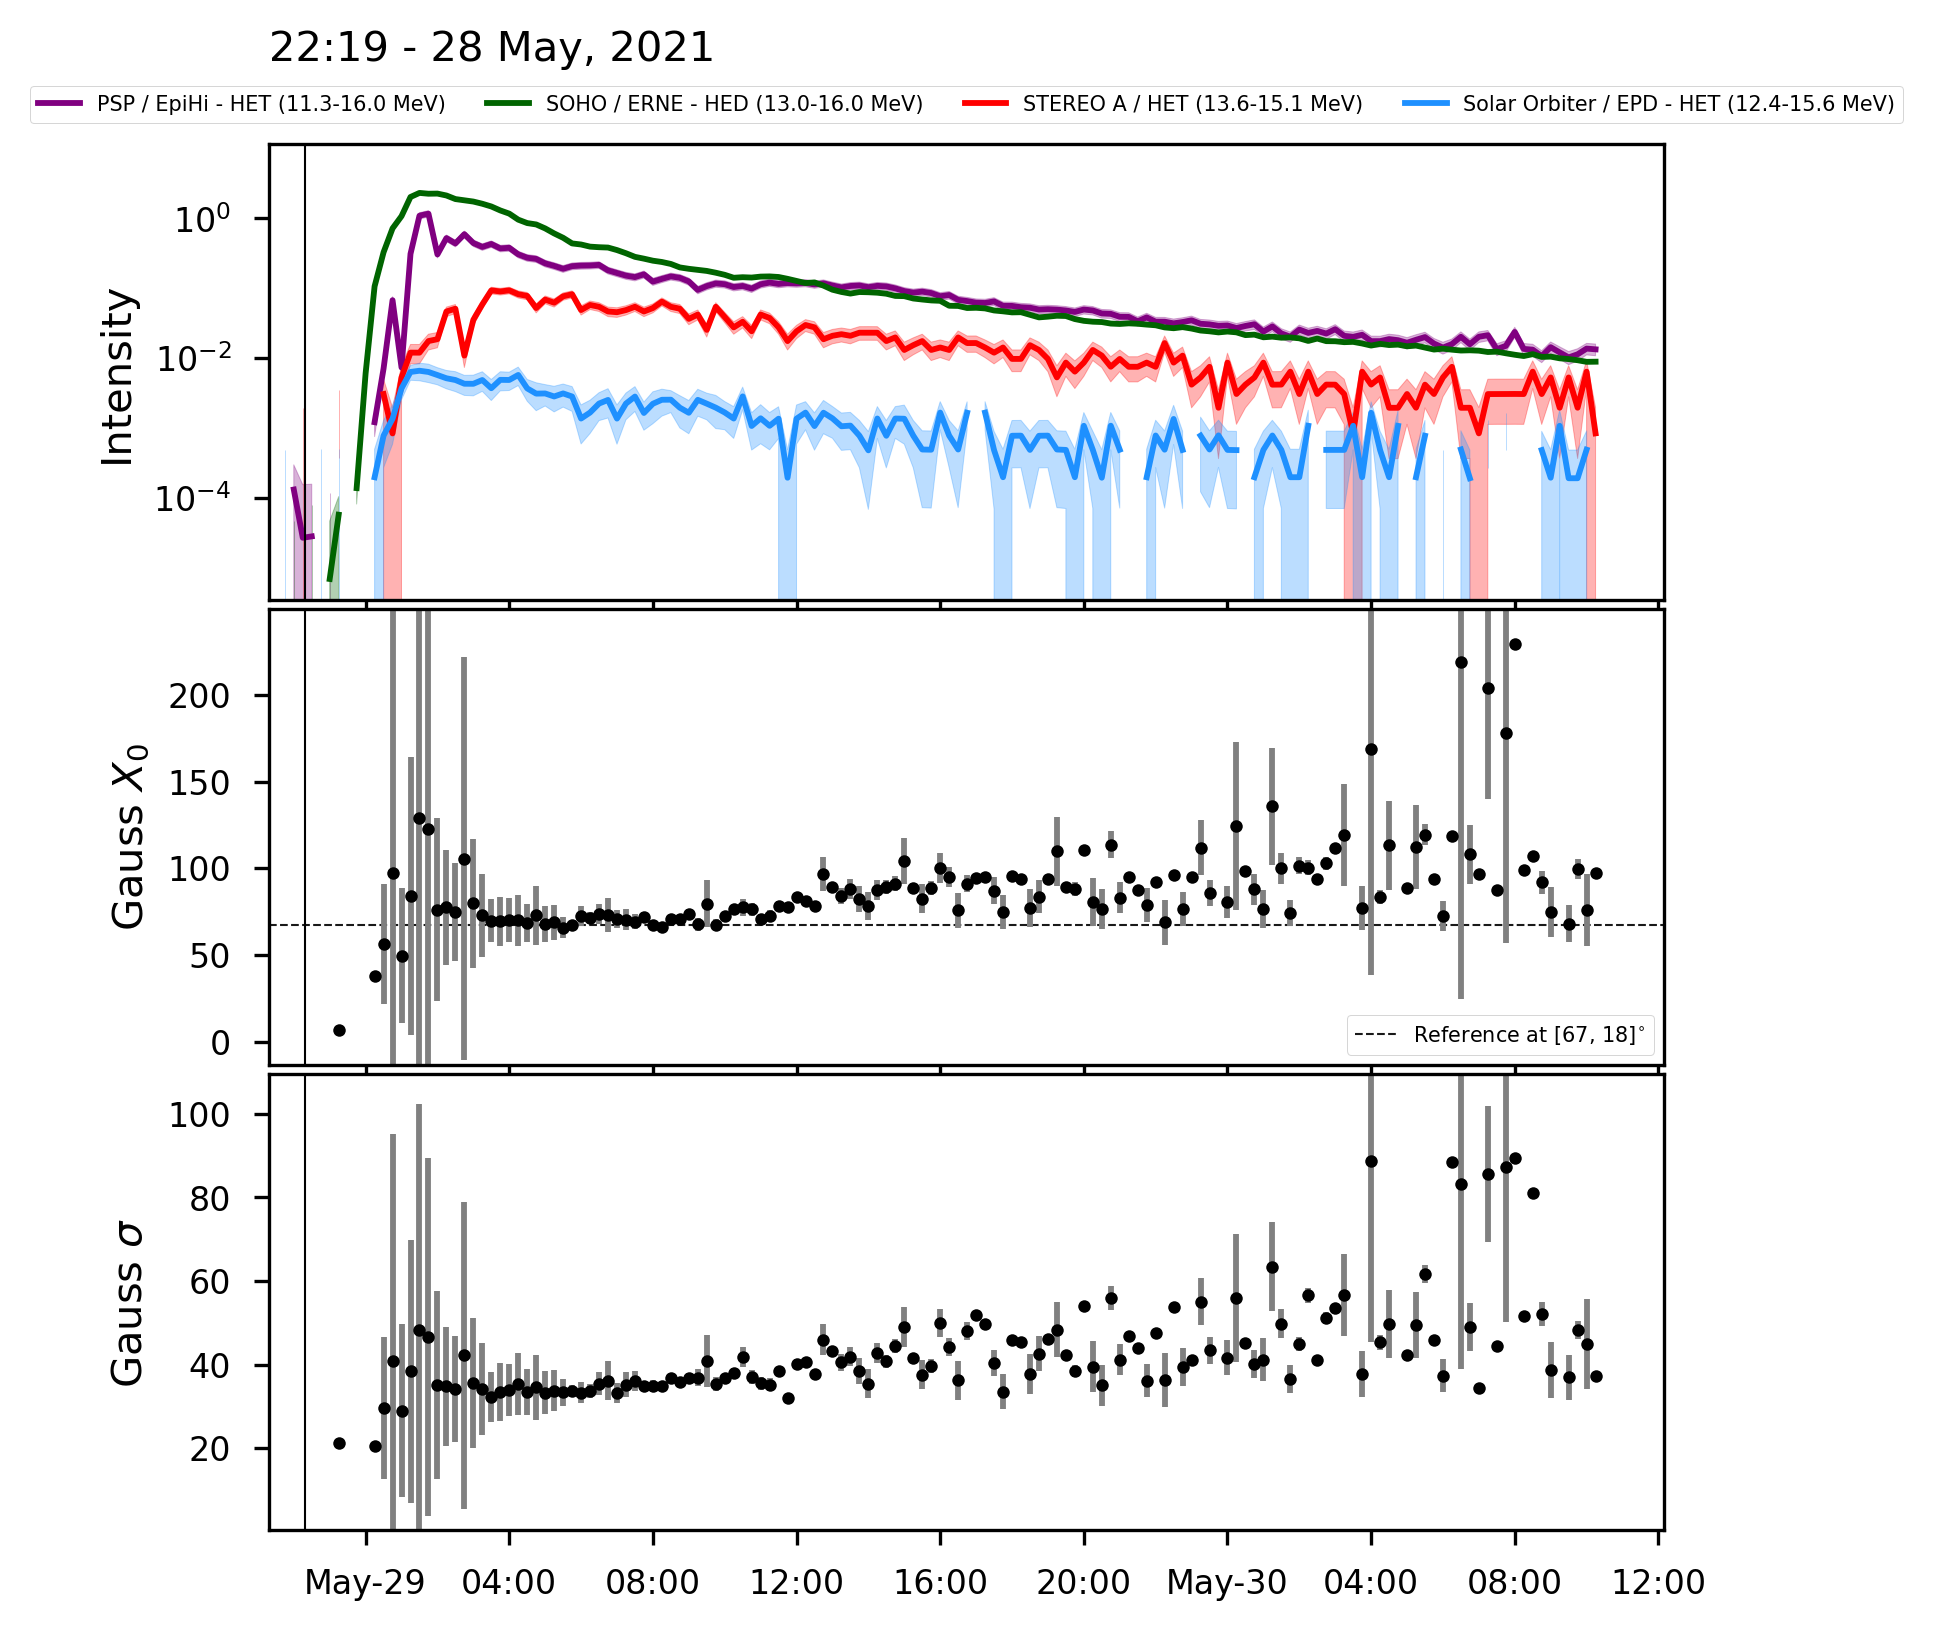

In [14]:
solar_event.plot_Gauss_results()

### Plot a simple curve for a single timestep
[Return to top](#Table-of-Contents)

If only a single timestep with just the fitted Gaussian curve is required then this function can be called with the given timestep given in a datetime format.

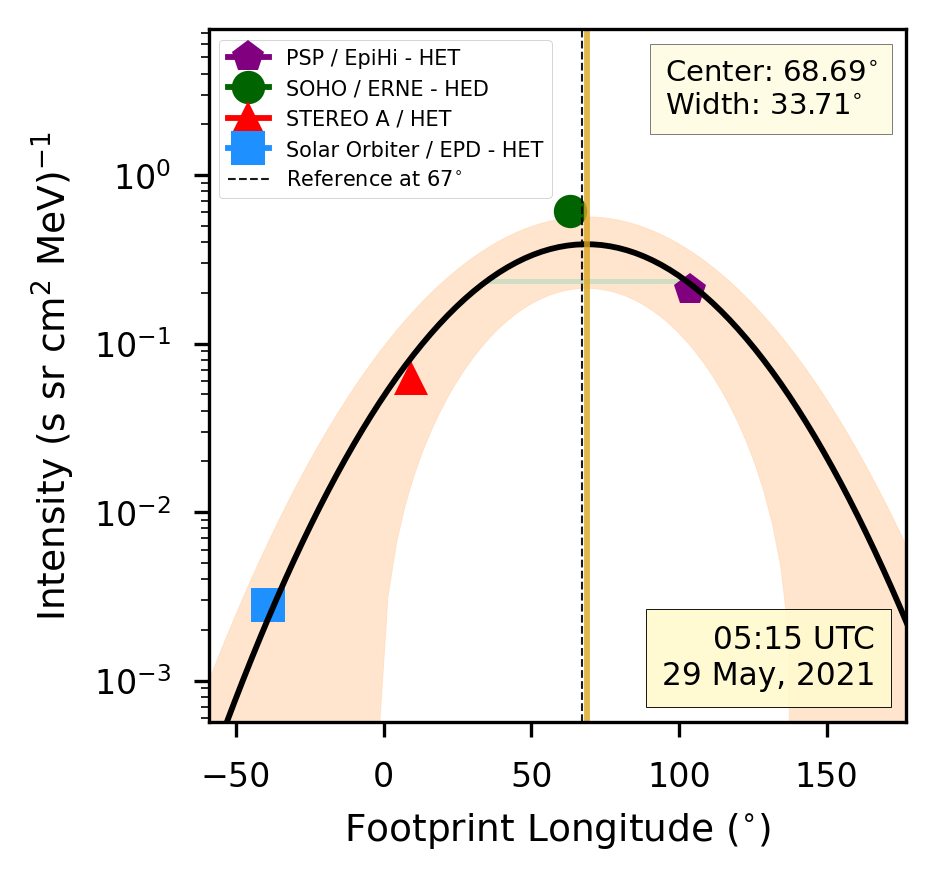

In [15]:
solar_event.plot_simple_curve_at_timestep(dt.datetime(2021,5,29,5,15))

# Appendix
[Return to top](#Table-of-Contents)

__Load the data__ \
In this method, we are downloading the spacecraft's positional data using Solar-MACH and the intensity (and intensity uncertainty) data for the given proton energy channels (in this notebook the given energy range is approximately 11-16 MeV).

For instruments with multiple viewing directions, the directions are averaged to provide omni-directional data, and for instruments with only one viewing direction (SOHO /HED; STEREO A /HET) we simply take the data as is.

If a range of channels is provided then they are merged using a weighted sum method, then the data is averaged to the specified intervals (this value is given using the `resampling` variable).

For options on utilising other energy ranges, refer to the channels listed in the following table:
| Spacecraft-Instrument |	~14 MeV Protons |	25-40 MeV Protons |
|---|---|---|
| PSP /EpiHi-HET |	`[3,4]` |	`[8,9]`|
| SOHO /ERNE-HED |	`[0]` |	`[3,4]`|
| Solar Orbiter /EPD-HET |	`[10,12]` |	`[19,24]` |
| STEREO A /HET |	`[0]` |	`[5,8]` |

***

__Background Subtraction__ \
Calculates the average intensity value of the background time period and reduces the full dataset by this value.
***

__Intercalibration__ \
This method adjusts the intensity data so as to calibrate each instrument to one common baseline. In this work, STEREO A /HET is the baseline and the only instrument that we have found (for this energy range and species) that requires an intercalibration factor is SOHO /ERNE-HED (see [Richardson et al. 2014](https://link.springer.com/article/10.1007/s11207-014-0524-8) for more information).

The data is adjusted using: $I_{new} = I_{old} \cdot IC$ where $IC$ is the intercalibration factor.

**Only change the intercalibration factors if you have found studies to support the change.** \
The values given below are from [Richardson et al. 2014](https://link.springer.com/article/10.1007/s11207-014-0524-8):
- For ~14 MeV protons: all spacecraft factors should be `1`, except SOHO which should be `0.67`.
- For 25-40 MeV protons: all spacecraft factors should be `1`.

***

__Radial Scaling__ \
This method uses the equation presented in [Farwa, et al. (2025)](https://www.aanda.org/articles/aa/abs/2025/01/aa50945-24/aa50945-24.html) and the values for 4-13 MeV and 27-37 MeV protons from [Lario et al. (2006)](https://iopscience.iop.org/article/10.1086/508982).
- For ~14 MeV protons: $(a\pm b)=(2.14 \pm 0.26)$
- For 25-40 MeV protons: $(a\pm b)=(1.97 \pm 0.27)$

The scaled intensity is calculated as $I_{1 au} = I \cdot R^{a\pm b}$, where $R$ is the radial distance, $I$ is the original intensity, and the scaling factors are given as $a \pm b$.

To calculate the scaled uncertainty, we use the following procedure:
1. Calculate the boundary limits for the intensity calculation (e.g. $I_+ = I\cdot R^{a+b}$; $I_- = I\cdot R^{a-b}$; Therefore, $\Delta I_+ = |I_{1 au}-I_+|$ and $\Delta I_- = |I_{1 au}-I_-|$ are the limits.
2. Find the higher boundary limit, as long as it is < the nominal value ($I_{1 au}$).
3. Calculate the scaled uncertainty value: $\Delta I_{1 au} = \Delta I \cdot R^a$.
4. Combine both to get a final uncertainty value: $\Delta I_{1 au, final} = \sqrt{(max[\Delta I_-, \Delta I_+])^2 + (\Delta I_{1 au})^2}$.

Lastly: This final uncertainty value is checked so that it is still less than the intensity value!
***

__Gaussian Curve Fitting__\
To calculate the Gaussian curve we use $f = A \cdot \exp\left[ \frac{-(x - X_0)^2}{2 \sigma^2} \right]$ where $A$ is the height of the curve, $X_0$ is the center of the curve, and $\sigma$ is the standard deviation which influences the 'width' of the curve. In order to plot these values on the curves in the Gaussian fit plots (i.e. straight lines at the center etc) the sigma value is plotted with `y = (0.6065) 10^{A}`, `xmin = X_0 - sigma`, and `xmax = X_0 + sigma`.

The logarithmic Gaussian curve is calculated with the same variables using $f = \log A - \frac{(x - X_0)^2}{2 \ln(10) \sigma^2}.$

The example in the figure uses the following parameters: $A=100, X_0=50,$ and $\sigma=20$.

<div>
    <img src="spatial_analysis/GaussianCurveExamples.png" width="800"/>
</div>

***

## Glossary
[Return to top](#Table-of-Contents)

- `*.load_spacecraft_data(channels={...}, resampling='...')`
  Downloads and stores the relevant observed data for the tool to use. The list of spacecraft is taken from the keys of the dictionary passed to `channels`.
- `*.background_subtract(background_window=[...], perform_process=True)`
  Calculates the average background and subtracts that value from the rest of the observed data. The background is defined in the array that is passed (i.e. \[start, end\]). To opt out of the process and continue without background subtracting, the boolean `perform_process` can be set to false, but the function must still run to continue with the tool.
- `*.intercalibrate(intercalibration_factors={...}, perform_process=True)`
  Adjusts the observed data by the factors provided in the dictionary. To opt out of the process and continue without intercalibrating, the boolean `perform_process` can be set to false, but the function must still run to continue with the tool.
- `*.radial_scale(radial_scaling_factors=[...], perform_process=True)`
  Adjusts the observed data based on the values provided in the array and the observers radial distance. To opt out of the process and continue without radially scaling, the boolean `perform_process` can be set to false, but the function must still run to continue with the tool.

***

- `*.plot_peak_fits(window_length=10)`
  Calculates and plots the peak intensity values of each observer and the fitted Gaussian curve, alongside the intensity time-series. The window to determine the peaks can be provided in the form of _hours after the start of the event_, the default value is 10 hours after the event start.
- `*.calc_Gaussian_fit()`
  Calculates and plots the intensity as a function of longitudinal position of each observer and the fitted Gaussian curve, alongside the intensity time-series for each time interval. A gif of all the time steps is produced at the end.

***

- `*.get_spacecraft_list()`
  Returns the list of spacecraft included in the current run of the tool
- `*.get_sc_df('sc')`
  Returns the data for the given spacecraft (`sc`) or if provided `'Gauss'` then it will return the results of fitting the Gaussian curve.
- `*.get_peak_data()`
  Returns the data and results for fitting the peak intensity data.
- `*.save_df_to_csv()`
  Saves the observed intensity and location data into a multi-indexed csv file for use outside of the tool.

***
  
- `*.plot_intensities()`
  Plots the intensity time series of all the provided spacecraft. Can also pass the keyword argument: `background_window=[start, end]` with start and end dates to provide a highlighted region in the plot.
- `*.plot_Gauss_results()`
  Plots the time profiles for the intensity, Gaussian center, and Gaussian width, respectively. This is the final result for this tool.